In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pip install opendatasets

In [ ]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/chandrayansinha/medical-note-extraction')

Dataset URL: https://www.kaggle.com/datasets/chandrayansinha/medical-note-extraction


100%|██████████| 8.95M/8.95M [00:00<00:00, 843MB/s]

In [ ]:
import numpy as np
import pandas as pd
import json
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score ,precision_score ,recall_score ,f1_score ,confusion_matrix
from transformers import AutoTokenizer, AutoModel

In [ ]:
df = pd.read_csv('/content/medical-note-extraction/train.csv')
df.head()

,ID,Note,json
0,1,**Clinical Notes**\n\n**Patient Information:**...,"{""patient_info"": {""age"": 41, ""gender"": ""Male""}..."
1,2,Clinical Notes:\n\nPatient: 56-year-old male\n...,"{""patient_info"": {""age"": 56, ""gender"": ""Male""}..."
2,3,Clinical Notes:\n\nPatient: 73-year-old female...,"{""patient_info"": {""age"": 73, ""gender"": ""Female..."
3,4,**Clinical Notes**\n\n**Patient Information:**...,"{""patient_info"": {""age"": 32, ""gender"": ""Female..."
4,5,"**Clinical Notes**\n\n**Patient:** Male, age 5...","{""patient_info"": {""age"": 51, ""gender"": ""Male""}..."


In [ ]:
print(df['Note'].iloc[0])

**Clinical Notes**

**Patient Information:**
- Age: 41 years old
- Gender: Male

**Visit Motivation:** Anemia evaluation

**Chief Complaints and Symptoms:**
The patient presents with complaints of anemia, fever, fatigue, difficulty breathing (dyspnea), vomiting, dizziness, blurred vision, wheezing, and pale skin. The patient reports that these symptoms have been progressively worsening over the past few weeks.

**History of Present Illness:**
- **Fever**: Intermittent low-grade fevers for approximately 2 weeks.
- **Fatigue**: Persistent and severe fatigue affecting daily activities.
- **Difficulty Breathing (Dyspnea)**: Experiencing shortness of breath, particularly with exertion. No history of chronic respiratory conditions.
- **Vomiting**: Occasional episodes of non-bilious vomiting for the past week.
- **Dizziness**: Episodes of dizziness, especially upon standing, which can be severe enough to cause near-fainting spells.
- **Blurred Vision**: New onset of blurred vision, with occas

In [ ]:
df['json'].iloc[0]

'{"patient_info": {"age": 41, "gender": "Male"}, "visit_motivation": "Anemia", "symptoms": ["fever", "fatigue", "difficulty_breathing", "vomiting", "dizziness", "blurred_vision", "wheezing", "pale_skin"], "vital_signs": {"heart_rate": {"value": 114, "unit": "bpm"}, "oxygen_saturation": {"value": 98.4, "unit": "%"}, "cholesterol_level": {"value": 132.8, "unit": "mg/dL"}, "glucose_level": {"value": 110.6, "unit": "mg/dL"}}}'

In [ ]:
df['disease'] = df['json'].str.split('"visit_motivation": ' ,expand=True)[1].str.split('"' ,expand=True)[1]

In [ ]:
df['disease'].value_counts()

,count
disease,
Urinary Tract Infection (UTI),598
Hypertension (High Blood Pressure),593
Allergies,584
Gastroesophageal Reflux Disease (GERD),582
Eczema (Atopic Dermatitis),578
Anxiety Disorders,571
Strep Throat,567
Influenza (Flu),559
Tuberculosis (TB),535


In [ ]:
import json

def parse_json(x):
    if isinstance(x, str):
        try:
            return json.loads(x)
        except:
            return {}
    return x

df["json_parsed"] = df["json"].apply(parse_json)


In [ ]:
import re

def clean_note(text):
    if not isinstance(text, str):
        return ""

    # Remove markdown-like bold patterns
    text = re.sub(r"\*\*|__", "", text)

    # Remove excessive newlines
    text = re.sub(r"\n+", "\n", text)

    # Remove extra spaces
    text = re.sub(r"\s+", " ", text)

    return text.strip()

df["clean_note"] = df["Note"].apply(clean_note)

In [ ]:
df['clean_note'].iloc[0]

'Clinical Notes Patient Information: - Age: 41 years old - Gender: Male Visit Motivation: Anemia evaluation Chief Complaints and Symptoms: The patient presents with complaints of anemia, fever, fatigue, difficulty breathing (dyspnea), vomiting, dizziness, blurred vision, wheezing, and pale skin. The patient reports that these symptoms have been progressively worsening over the past few weeks. History of Present Illness: - Fever: Intermittent low-grade fevers for approximately 2 weeks. - Fatigue: Persistent and severe fatigue affecting daily activities. - Difficulty Breathing (Dyspnea): Experiencing shortness of breath, particularly with exertion. No history of chronic respiratory conditions. - Vomiting: Occasional episodes of non-bilious vomiting for the past week. - Dizziness: Episodes of dizziness, especially upon standing, which can be severe enough to cause near-fainting spells. - Blurred Vision: New onset of blurred vision, with occasional transient visual disturbances. - Wheezing

In [ ]:
processed_df = df[["clean_note", "disease"]].dropna()
processed_df = processed_df[processed_df["clean_note"] != ""]
processed_df.head()

,clean_note,disease
0,Clinical Notes Patient Information: - Age: 41 ...,Anemia
1,Clinical Notes: Patient: 56-year-old male Chie...,Allergies
2,Clinical Notes: Patient: 73-year-old female Ch...,Diabetes (Type 2)
3,Clinical Notes Patient Information: - Age: 32 ...,Allergies
4,"Clinical Notes Patient: Male, age 51 Visit Mot...",Tuberculosis (TB)


In [ ]:
model_name = "nlpie/tiny-clinicalbert"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model_bert = AutoModel.from_pretrained(model_name)

model_bert.eval()

# --- Define the Pooling Function (using PyTorch operations) ---
def mean_pooling_pt(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state

    input_mask_expanded = attention_mask.unsqueeze(-1).float()

    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, dim=1)

    sum_mask = torch.clamp(input_mask_expanded.sum(dim=1), min=1e-9)

    mean_pooled = sum_embeddings / sum_mask

    return mean_pooled.detach().cpu().numpy()

# --- Define the Embedding Function ---
def embed(text):
    encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)

    device = next(model_bert.parameters()).device
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}

    with torch.no_grad():
        model_output = model_bert(**encoded_input)

    sentence_embedding = mean_pooling_pt(model_output, encoded_input['attention_mask'])

    return sentence_embedding.flatten()


Some weights of BertModel were not initialized from the model checkpoint at nlpie/tiny-clinicalbert and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
embeddings = []

for i, text in enumerate(processed_df["clean_note"]):
    emb = embed(text)
    embeddings.append(emb)
    if i % 100 == 0:
        print(f"Processed {i} notes.")

embeddings = np.vstack(embeddings)

print(f"\nGenerated embeddings shape: {embeddings.shape}")

Processed 0 notes.
Processed 100 notes.
Processed 200 notes.
Processed 300 notes.
Processed 400 notes.
Processed 500 notes.
Processed 600 notes.
Processed 700 notes.
Processed 800 notes.
Processed 900 notes.
Processed 1000 notes.
Processed 1100 notes.
Processed 1200 notes.
Processed 1300 notes.
Processed 1400 notes.
Processed 1500 notes.
Processed 1600 notes.
Processed 1700 notes.
Processed 1800 notes.
Processed 1900 notes.
Processed 2000 notes.
Processed 2100 notes.
Processed 2200 notes.
Processed 2300 notes.
Processed 2400 notes.
Processed 2500 notes.
Processed 2600 notes.
Processed 2700 notes.
Processed 2800 notes.
Processed 2900 notes.
Processed 3000 notes.
Processed 3100 notes.
Processed 3200 notes.
Processed 3300 notes.
Processed 3400 notes.
Processed 3500 notes.
Processed 3600 notes.
Processed 3700 notes.
Processed 3800 notes.
Processed 3900 notes.
Processed 4000 notes.
Processed 4100 notes.
Processed 4200 notes.
Processed 4300 notes.
Processed 4400 notes.
Processed 4500 notes.


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(processed_df["disease"])

In [ ]:
X = np.vstack(embeddings)
y = y_encoded

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

In [ ]:
X_train_t, X_val_t, y_train_t, y_val_t = train_test_split(X, y,
                                                          test_size=0.2,
                                                          random_state=42,
                                                          stratify=y
                                                          )

In [ ]:
num_classes = len(le.classes_)
input_dim = 312

class ANNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ANNModel, self).__init__()

        self.fc1 = nn.Linear(input_dim, 512)
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128, momentum=0.01, eps=0.001)

        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64, momentum=0.01, eps=0.001)

        self.fc5 = nn.Linear(64, 32)
        self.bn5 = nn.BatchNorm1d(32, momentum=0.01, eps=0.001)

        self.fc6 = nn.Linear(32, num_classes)

        self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        x = F.relu(self.fc3(x))
        x = self.bn3(x)

        x = F.relu(self.fc4(x))
        x = self.bn4(x)

        x = F.relu(self.fc5(x))
        x = self.bn5(x)

        x = self.fc6(x)
        return x


model = ANNModel(input_dim=input_dim, num_classes=num_classes)
print(model)

ANNModel(
  (fc1): Linear(in_features=312, out_features=512, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (bn4): BatchNorm1d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (bn5): BatchNorm1d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  (fc6): Linear(in_features=32, out_features=20, bias=True)
)


In [ ]:
# --- Hyperparameters ---
batch_size = 32
epochs = 500
patience = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- DataLoader ---
train_dataset = torch.utils.data.TensorDataset(X_train_t, y_train_t)
val_dataset = torch.utils.data.TensorDataset(X_val_t, y_val_t)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# --- Instantiate model ---
model = ANNModel(input_dim=input_dim, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-7)

# --- Early Stopping ---
best_val_loss = np.inf
counter = 0
best_model_state = None

# --- Training Loop ---
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_acc = accuracy_score(all_labels, all_preds)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Restore best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)


Epoch 1/500 | Train Loss: 3.1844 | Val Loss: 2.8405 | Val Acc: 0.1002
Epoch 2/500 | Train Loss: 2.4252 | Val Loss: 2.0304 | Val Acc: 0.3811
Epoch 3/500 | Train Loss: 1.8964 | Val Loss: 1.5577 | Val Acc: 0.5122
Epoch 4/500 | Train Loss: 1.6869 | Val Loss: 1.3338 | Val Acc: 0.5894
Epoch 5/500 | Train Loss: 1.5089 | Val Loss: 1.1667 | Val Acc: 0.6291
Epoch 6/500 | Train Loss: 1.3747 | Val Loss: 1.0920 | Val Acc: 0.6545
Epoch 7/500 | Train Loss: 1.2724 | Val Loss: 1.0471 | Val Acc: 0.6697
Epoch 8/500 | Train Loss: 1.2070 | Val Loss: 0.9741 | Val Acc: 0.6827
Epoch 9/500 | Train Loss: 1.1340 | Val Loss: 0.8746 | Val Acc: 0.7252
Epoch 10/500 | Train Loss: 1.1163 | Val Loss: 0.8327 | Val Acc: 0.7386
Epoch 11/500 | Train Loss: 1.0512 | Val Loss: 0.9547 | Val Acc: 0.7090
Epoch 12/500 | Train Loss: 1.0119 | Val Loss: 0.7832 | Val Acc: 0.7603
Epoch 13/500 | Train Loss: 0.9640 | Val Loss: 0.7747 | Val Acc: 0.7557
Epoch 14/500 | Train Loss: 0.9383 | Val Loss: 0.7691 | Val Acc: 0.7584
Epoch 15/500 | 

In [ ]:
# --- Evaluation on validation set ---
model.eval()
with torch.no_grad():
    outputs = model(X_val_t.to(device))
    preds = torch.argmax(outputs, dim=1).cpu().numpy()
    labels = y_val_t.numpy()

accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds, average='weighted')
recall = recall_score(labels, preds, average='weighted')
conf_mat = confusion_matrix(labels, preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.8915
Precision: 0.8945
Recall: 0.8915


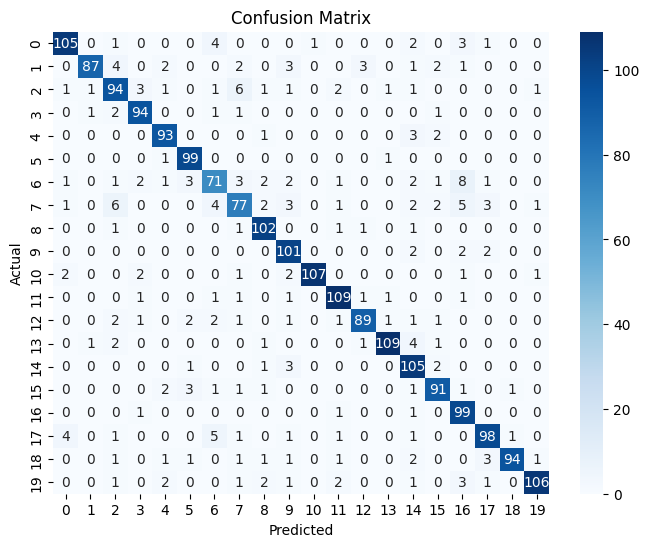

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# --- Save model ---
torch.save(model.state_dict(), "disease_classifier_ann_model.pth")
print("Model saved as ann_model.pth")

Model saved as ann_model.pth


In [ ]:
import os

# Get the size of the file in bytes
file_size_bytes = os.path.getsize("disease_classifier_ann_model.pth")

# Convert bytes to megabytes
file_size_mb = file_size_bytes / (1024 * 1024)

print(f"Size of disease_classifier.pkl: {file_size_mb:.2f} MB")

Size of disease_classifier.pkl: 1.29 MB


In [ ]:
from google.colab import files
files.download('disease_classifier_ann_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def get_all_class_probabilities(model, input_embedding, le):
    if input_embedding.ndim == 1:
        input_tensor = torch.tensor(input_embedding, dtype=torch.float32).unsqueeze(0).to(device)
    else:
        input_tensor = torch.tensor(input_embedding, dtype=torch.float32).to(device)

    model.eval()

    with torch.no_grad():
        logits = model(input_tensor)
        probabilities = F.softmax(logits, dim=1).cpu().numpy()[0]

    class_names = le.classes_
    prob_dict = dict(zip(class_names, probabilities))

    sorted_probs = sorted(prob_dict.items(), key=lambda item: item[1], reverse=True)

    return sorted_probs


In [ ]:
text = '''The patient reports persistent fatigue, low motivation, and difficulty concentrating. There is a constant sense of heaviness in the chest, accompanied by intermittent awareness of heartbeats. The patient expresses feelings of hopelessness and reports poor appetite and disrupted sleep patterns. Episodes of restlessness and excessive worry are noted, particularly when experiencing chest discomfort. The patient avoids physical activity due to fear of worsening symptoms. Emotional stress appears to amplify physical sensations, making it challenging to distinguish psychological distress from possible cardiac symptoms.
'''

In [ ]:
emb = embed(text).reshape(1, -1)

results = get_all_class_probabilities(model, emb.reshape(1,-1), le)

for class_name, prob in results:
    print(f"{class_name:<25} : {prob*100:>8.2f}%")

Anxiety Disorders         :    66.80%
Diabetes (Type 2)         :    11.95%
Heart Disease (Coronary Artery Disease) :     8.89%
Hypertension (High Blood Pressure) :     4.65%
Allergies                 :     2.45%
Depression                :     1.82%
Anemia                    :     1.32%
Common Cold               :     0.93%
Tuberculosis (TB)         :     0.47%
Strep Throat              :     0.23%
Sinusitis                 :     0.14%
Gastroesophageal Reflux Disease (GERD) :     0.13%
Urinary Tract Infection (UTI) :     0.12%
Asthma                    :     0.03%
Influenza (Flu)           :     0.02%
Ear Infection (Otitis Media) :     0.01%
Pneumonia                 :     0.01%
Chronic Obstructive Pulmonary Disease (COPD) :     0.01%
Eczema (Atopic Dermatitis) :     0.01%
COVID-19                  :     0.00%
